Match prompt muon well first, it is the base for dSA identification

In [1]:
from coffea import hist
from coffea.hist.hist_tools import Interval
import coffea.processor as processor
from coffea.analysis_objects import JaggedCandidateArray
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward
from uproot_methods import TLorentzVectorArray

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [85]:
import json
import os
from os.path import join

dataset4mu_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_4mu_v2.json')))
dataset2mu2e_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_2mu2e_v2.json')))
backgrounds_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/backgrounds_v2.json')))

In [89]:
class promptMuonProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        self._accumulator = processor.dict_accumulator({
            'cutflow': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        ## recomuons/pfmuons
        recomuons = JaggedCandidateArray.candidatesfromcounts(
            df['muon_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['muon_p4.fCoordinates.fX'],
                                                 df['muon_p4.fCoordinates.fY'],
                                                 df['muon_p4.fCoordinates.fZ'],
                                                 df['muon_p4.fCoordinates.fT']),
            ispfmuon=df['muon_isPFMuon'],
            selector=df['muon_id_selectors'],
        )
        recomuons.add_attributes( isloose=(recomuons.selector&(1<<0)==(1<<0)),
                                  ismedium=(recomuons.selector&(1<<1)==(1<<1)),
                                  istight=(recomuons.selector&(1<<3)==(1<<3)),
                                  pfisoveryloose=(recomuons.selector&(1<<6)==(1<<6)),
                                  pfisoloose=(recomuons.selector&(1<<7)==(1<<7)),
                                  pfisomedium=(recomuons.selector&(1<<8)==(1<<8)),
                                  tkisoloose=(recomuons.selector&(1<<11)==(1<<11)),
                                  tkisotight=(recomuons.selector&(1<<12)==(1<<12)),
                                  intime=(recomuons.selector&(1<<23)==(1<<23)),
                                )
        recomuons = recomuons[(recomuons.pt>5.)&(np.abs(recomuons.eta)<2.4)]
                
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['gen_p4.fCoordinates.fX'],
                                                 df['gen_p4.fCoordinates.fY'],
                                                 df['gen_p4.fCoordinates.fZ'],
                                                 df['gen_p4.fCoordinates.fT']),
            pid=df['gen_pid'],
            vx=df['gen_vtx.fCoordinates.fX'],
            vy=df['gen_vtx.fCoordinates.fY'],
            vz=df['gen_vtx.fCoordinates.fZ'],
        )
        genparticles.add_attributes(vxy=np.hypot(genparticles.vx, genparticles.vy))
        genmuons = genparticles[(np.abs(genparticles.pid)==13)]

        # prompt-like
        genmuons = genmuons[genmuons.vxy<3]

        output['cutflow']['total-pf'] += recomuons[recomuons.ispfmuon].counts.sum()
        output['cutflow']['total-loose'] += recomuons[recomuons.isloose].counts.sum()
        output['cutflow']['total-medium'] += recomuons[recomuons.ismedium].counts.sum()
        output['cutflow']['total-tight'] += recomuons[recomuons.istight].counts.sum()
        output['cutflow']['total-pfisoVeryLoose'] += recomuons[recomuons.pfisoveryloose].counts.sum()
        output['cutflow']['total-pfisoLoose'] += recomuons[recomuons.pfisoloose].counts.sum()
        output['cutflow']['total-pfisoMedium'] += recomuons[recomuons.pfisomedium].counts.sum()
        output['cutflow']['total-looseLoose'] += recomuons[recomuons.pfisoloose&recomuons.isloose].counts.sum()
        output['cutflow']['total-looseVeryloose'] += recomuons[recomuons.pfisoveryloose&recomuons.isloose].counts.sum()
        output['cutflow']['total-matchedWithGen'] += recomuons.match(genmuons, deltaRCut=0.2).flatten().sum()
        output['cutflow']['total-tkIsoLoose'] += recomuons[recomuons.tkisoloose].counts.sum()
        output['cutflow']['total-tkIsoTight'] += recomuons[recomuons.tkisotight].counts.sum()
        output['cutflow']['total-inTime'] += recomuons[recomuons.intime].counts.sum()
        output['cutflow']['total-comb'] += recomuons[recomuons.pfisoveryloose&recomuons.isloose&recomuons.intime].counts.sum()
        
        output['cutflow']['total-gen'] += genmuons.counts.sum()
        output['cutflow']['matched-found'] += genmuons.match(recomuons, deltaRCut=0.2).flatten().sum()
        
        matchedidx = genmuons.argmatch(recomuons, deltaRCut=0.2)
        matchedRecoMu = recomuons[matchedidx[matchedidx!=-1]]
        output['cutflow']['loose-found'] += matchedRecoMu[matchedRecoMu.isloose].counts.sum()
        output['cutflow']['medium-found'] += matchedRecoMu[matchedRecoMu.ismedium].counts.sum()
        output['cutflow']['pfisoVeryLoose-found'] += matchedRecoMu[matchedRecoMu.pfisoveryloose].counts.sum()
        output['cutflow']['pfisoLoose-found'] += matchedRecoMu[matchedRecoMu.pfisoloose].counts.sum()
        output['cutflow']['pfisoMedium-found'] += matchedRecoMu[matchedRecoMu.pfisomedium].counts.sum()
        output['cutflow']['looseLoose-found'] += matchedRecoMu[matchedRecoMu.pfisoloose&matchedRecoMu.isloose].counts.sum()
        output['cutflow']['looseVeryloose-found'] += matchedRecoMu[matchedRecoMu.pfisoveryloose&matchedRecoMu.isloose].counts.sum()
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [90]:
dataset={
#     '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
#     '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

# dataset={
#     '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
#     '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
#     '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
# }


output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=promptMuonProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 10/10 [00:03<00:00,  1.44s/items]


In [91]:
pd.Series(dict(output['cutflow']))

total-pf                19799
total-loose             15719
total-medium             9279
total-tight              2781
total-pfisoVeryLoose    50144
total-pfisoLoose        47453
total-pfisoMedium       46011
total-looseLoose        13229
total-looseVeryloose    13769
total-matchedWithGen     1012
total-tkIsoLoose        53548
total-tkIsoTight        52709
total-inTime            55155
total-comb              13634
total-gen                1046
matched-found            1039
loose-found               998
medium-found              944
pfisoVeryLoose-found     1025
pfisoLoose-found         1009
pfisoMedium-found        1001
looseLoose-found          968
looseVeryloose-found      984
dtype: int64

In [92]:
class promptMuonProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        self._accumulator = processor.dict_accumulator({
            'cutflow': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        ## recomuons/pfmuons
        recomuons = JaggedCandidateArray.candidatesfromcounts(
            df['muon_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['muon_p4.fCoordinates.fX'],
                                                 df['muon_p4.fCoordinates.fY'],
                                                 df['muon_p4.fCoordinates.fZ'],
                                                 df['muon_p4.fCoordinates.fT']),
            ispfmuon=df['muon_isPFMuon'],
            selector=df['muon_id_selectors'],
        )
        recomuons.add_attributes( isloose=(recomuons.selector&(1<<0)==(1<<0)),
                                  ismedium=(recomuons.selector&(1<<1)==(1<<1)),
                                  istight=(recomuons.selector&(1<<3)==(1<<3)),
                                  pfisoveryloose=(recomuons.selector&(1<<6)==(1<<6)),
                                  pfisoloose=(recomuons.selector&(1<<7)==(1<<7)),
                                  pfisomedium=(recomuons.selector&(1<<8)==(1<<8)),
                                  tkisoloose=(recomuons.selector&(1<<11)==(1<<11)),
                                  tkisotight=(recomuons.selector&(1<<12)==(1<<12)),
                                  intime=(recomuons.selector&(1<<23)==(1<<23)),
                                )
        recomuons = recomuons[(recomuons.pt>5.)&(np.abs(recomuons.eta)<2.4)]
                
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['gen_p4.fCoordinates.fX'],
                                                 df['gen_p4.fCoordinates.fY'],
                                                 df['gen_p4.fCoordinates.fZ'],
                                                 df['gen_p4.fCoordinates.fT']),
            pid=df['gen_pid'],
        )
        genmuons = genparticles[(np.abs(genparticles.pid)==13)]

        output['cutflow']['total-pf'] += recomuons[recomuons.ispfmuon].counts.sum()
        output['cutflow']['total-loose'] += recomuons[recomuons.isloose].counts.sum()
        output['cutflow']['total-medium'] += recomuons[recomuons.ismedium].counts.sum()
        output['cutflow']['total-tight'] += recomuons[recomuons.istight].counts.sum()
        output['cutflow']['total-pfisoVeryLoose'] += recomuons[recomuons.pfisoveryloose].counts.sum()
        output['cutflow']['total-pfisoLoose'] += recomuons[recomuons.pfisoloose].counts.sum()
        output['cutflow']['total-pfisoMedium'] += recomuons[recomuons.pfisomedium].counts.sum()
        output['cutflow']['total-looseLoose'] += recomuons[recomuons.pfisoloose&recomuons.isloose].counts.sum()
        output['cutflow']['total-looseVeryloose'] += recomuons[recomuons.pfisoveryloose&recomuons.isloose].counts.sum()
        output['cutflow']['total-matchedWithGen'] += recomuons.match(genmuons, deltaRCut=0.2).flatten().sum()
        output['cutflow']['total-tkIsoLoose'] += recomuons[recomuons.tkisoloose].counts.sum()
        output['cutflow']['total-tkIsoTight'] += recomuons[recomuons.tkisotight].counts.sum()
        output['cutflow']['total-inTime'] += recomuons[recomuons.intime].counts.sum()
        output['cutflow']['total-comb'] += recomuons[recomuons.pfisoveryloose&recomuons.isloose&recomuons.intime].counts.sum()
        
        output['cutflow']['total-gen'] += genmuons.counts.sum()
        output['cutflow']['matched-found'] += genmuons.match(recomuons, deltaRCut=0.2).flatten().sum()
        
        matchedidx = genmuons.argmatch(recomuons, deltaRCut=0.2)
        matchedRecoMu = recomuons[matchedidx[matchedidx!=-1]]
        output['cutflow']['loose-found'] += matchedRecoMu[matchedRecoMu.isloose].counts.sum()
        output['cutflow']['medium-found'] += matchedRecoMu[matchedRecoMu.ismedium].counts.sum()
        output['cutflow']['pfisoVeryLoose-found'] += matchedRecoMu[matchedRecoMu.pfisoveryloose].counts.sum()
        output['cutflow']['pfisoLoose-found'] += matchedRecoMu[matchedRecoMu.pfisoloose].counts.sum()
        output['cutflow']['pfisoMedium-found'] += matchedRecoMu[matchedRecoMu.pfisomedium].counts.sum()
        output['cutflow']['looseLoose-found'] += matchedRecoMu[matchedRecoMu.pfisoloose&matchedRecoMu.isloose].counts.sum()
        output['cutflow']['looseVeryloose-found'] += matchedRecoMu[matchedRecoMu.pfisoveryloose&matchedRecoMu.isloose].counts.sum()
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [94]:
dataset = backgrounds_['QCD']
output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=promptMuonProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 124/124 [00:28<00:00,  4.42items/s]


In [95]:
pd.Series(dict(output['cutflow']))

total-pf                104631
total-loose             104038
total-medium             98630
total-tight              91998
total-pfisoVeryLoose     23725
total-pfisoLoose         16532
total-pfisoMedium        14187
total-looseLoose          9389
total-looseVeryloose     14763
total-matchedWithGen    133254
total-tkIsoLoose         29639
total-tkIsoTight         27324
total-inTime            146091
total-comb               14583
total-gen               760298
matched-found           111848
loose-found             104820
medium-found            102576
pfisoVeryLoose-found     15446
pfisoLoose-found          9584
pfisoMedium-found         7847
looseLoose-found          9110
looseVeryloose-found     14766
dtype: int64

In [80]:
class promptMuonProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        pt_axis = hist.Bin('pt', '$p_T$ [GeV]', 50, 0, 100)
        eta_axis = hist.Bin('eta', '$\eta$', 48, -2.4, 2.4)
        dr_axis = hist.Bin('dr', '$\Delta$R', 50, 0, 0.5)
        self._accumulator = processor.dict_accumulator({
            'totalmu': hist.Hist('Counts', dataset_axis, pt_axis, eta_axis),
            'totalmupairdr': hist.Hist('Counts', dataset_axis, dr_axis),
            'genmatchedmu': hist.Hist('Counts', dataset_axis, pt_axis, eta_axis),
            'genmatchedmupairdr': hist.Hist('Counts', dataset_axis, dr_axis),
            'genmuondr': hist.Hist('Counts', dataset_axis, dr_axis),
            
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        ## recomuons/pfmuons
        recomuons = JaggedCandidateArray.candidatesfromcounts(
            df['muon_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['muon_p4.fCoordinates.fX'],
                                                 df['muon_p4.fCoordinates.fY'],
                                                 df['muon_p4.fCoordinates.fZ'],
                                                 df['muon_p4.fCoordinates.fT']),
            ispfmuon=df['muon_isPFMuon'],
            selector=df['muon_id_selectors'],
        )
        recomuons.add_attributes( isloose=(recomuons.selector&(1<<0)==(1<<0)),
                                  ismedium=(recomuons.selector&(1<<1)==(1<<1)),
                                  istight=(recomuons.selector&(1<<3)==(1<<3)),
                                  pfisoveryloose=(recomuons.selector&(1<<6)==(1<<6)),
                                  pfisoloose=(recomuons.selector&(1<<7)==(1<<7)),
                                  pfisomedium=(recomuons.selector&(1<<8)==(1<<8)),
                                )
        
                
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['gen_p4.fCoordinates.fX'],
                                                 df['gen_p4.fCoordinates.fY'],
                                                 df['gen_p4.fCoordinates.fZ'],
                                                 df['gen_p4.fCoordinates.fT']),
            pid=df['gen_pid'],
            charge=df['gen_charge'],
            vx=df['gen_vtx.fCoordinates.fX'],
            vy=df['gen_vtx.fCoordinates.fY'],
            vz=df['gen_vtx.fCoordinates.fZ'],
        )
        genparticles.add_attributes(vxy=np.hypot(genparticles.vx, genparticles.vy))
        genmuons = genparticles[(np.abs(genparticles.pid)==13)]

        # prompt-like
        genmuons = genmuons[genmuons.vxy<3]
        recomuons.add_attributes(genmatched=recomuons.match(genmuons, deltaRCut=0.2))
        recomuons = recomuons[(recomuons.pt>5.)&(np.abs(recomuons.eta)<2.4)]
        
        genmuonpairs = genmuons.distincts()
        genmuonpairs = genmuonpairs[genmuonpairs.i0.charge*genmuonpairs.i1.charge==-1]
        output['genmuondr'].fill(dataset=dataset, dr=genmuonpairs.i0.p4.delta_r(genmuonpairs.i1.p4).flatten())

        pfmuons = recomuons[recomuons.ispfmuon]
        output['totalmu'].fill(dataset=dataset, pt=pfmuons.pt.flatten(),
                              eta=pfmuons.eta.flatten())
        pfmuonpairs = pfmuons.distincts()
        output['totalmupairdr'].fill(dataset=dataset, dr=pfmuonpairs.i0.p4.delta_r(pfmuonpairs.i1.p4).flatten())
        
#         matchedidx = genmuons.argmatch(recomuons, deltaRCut=0.2)
#         matchedRecoMu = recomuons[matchedidx[matchedidx!=-1]]
#         output['genmatchedmu'].fill(dataset=dataset, pt=matchedRecoMu.pt.flatten(),
#                               eta=matchedRecoMu.eta.flatten())
        matchedRecoMu = recomuons[recomuons.genmatched]
        output['genmatchedmu'].fill(dataset=dataset, pt=matchedRecoMu.pt.flatten(),
                              eta=matchedRecoMu.eta.flatten())
        matchedRecoMuPairs = matchedRecoMu.distincts()
        output['genmatchedmupairdr'].fill(dataset=dataset, dr=matchedRecoMuPairs.i0.p4.delta_r(matchedRecoMuPairs.i1.p4).flatten())
        
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [83]:
dataset={
#     '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
#     '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

# dataset={
#     '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
#     '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
#     '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
# }

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=promptMuonProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 5/5 [00:03<00:00,  1.66items/s]


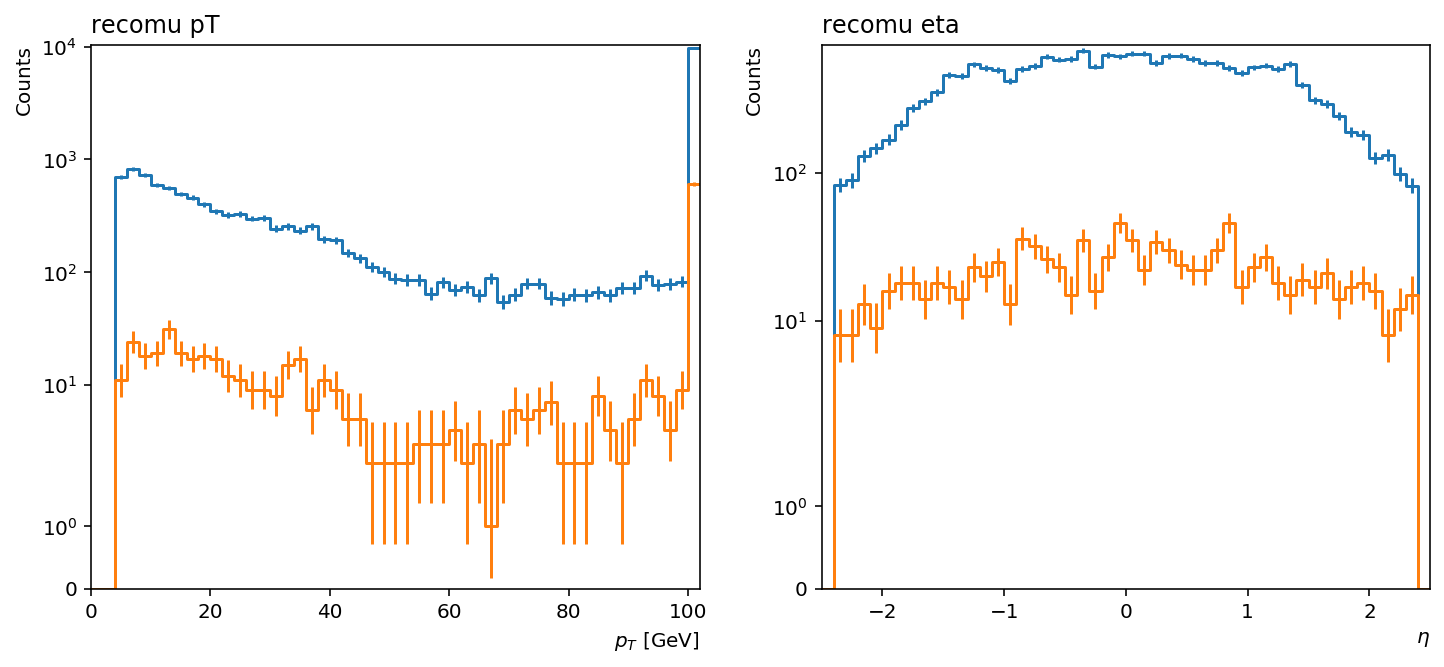

In [69]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
hist.plot1d(output['totalmu'].sum('eta', 'dataset', overflow='all'), ax=axes[0], overflow='over', density=False)
hist.plot1d(output['genmatchedmu'].sum('eta', 'dataset', overflow='all'), ax=axes[0], overflow='over', clear=False, density=False)

hist.plot1d(output['totalmu'].sum('pt', 'dataset', overflow='all'), ax=axes[1], overflow='all', density=False)
hist.plot1d(output['genmatchedmu'].sum('pt', 'dataset', overflow='all'), ax=axes[1], overflow='all', clear=False, density=False)

axes[0].set_title('recomu pT', ha='left', x=0)
axes[1].set_title('recomu eta', ha='left', x=0)
for ax in axes:
    ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

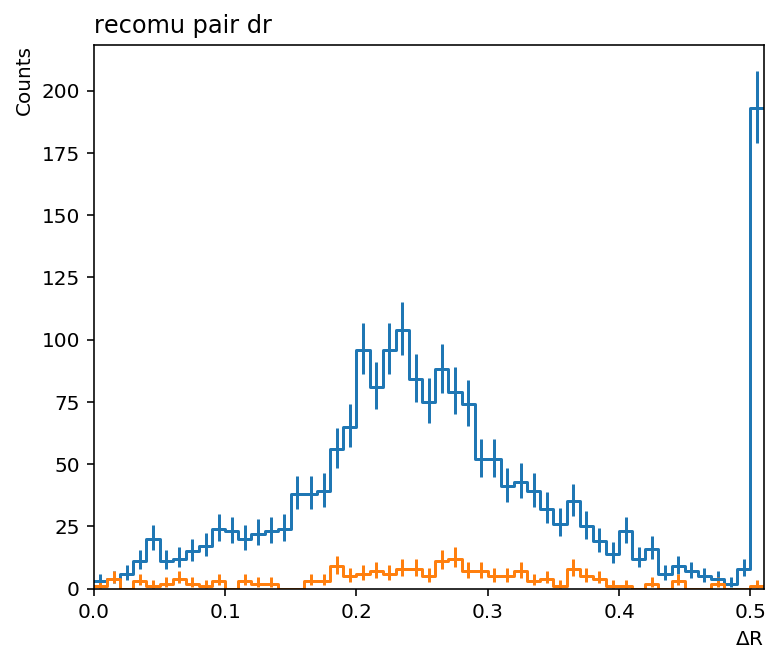

In [84]:
fig,axes=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['totalmupairdr'].sum('dataset', overflow='all'), ax=axes, overflow='over', density=False)
hist.plot1d(output['genmatchedmupairdr'].sum('dataset', overflow='all'), ax=axes, overflow='over', clear=False, density=False)


axes.set_title('recomu pair dr', ha='left', x=0)

# axes.set_yscale('symlog')
axes.set_xlabel(axes.get_xlabel(), x=1.0, ha="right")
axes.set_ylabel(axes.get_ylabel(), y=1.0, ha="right");

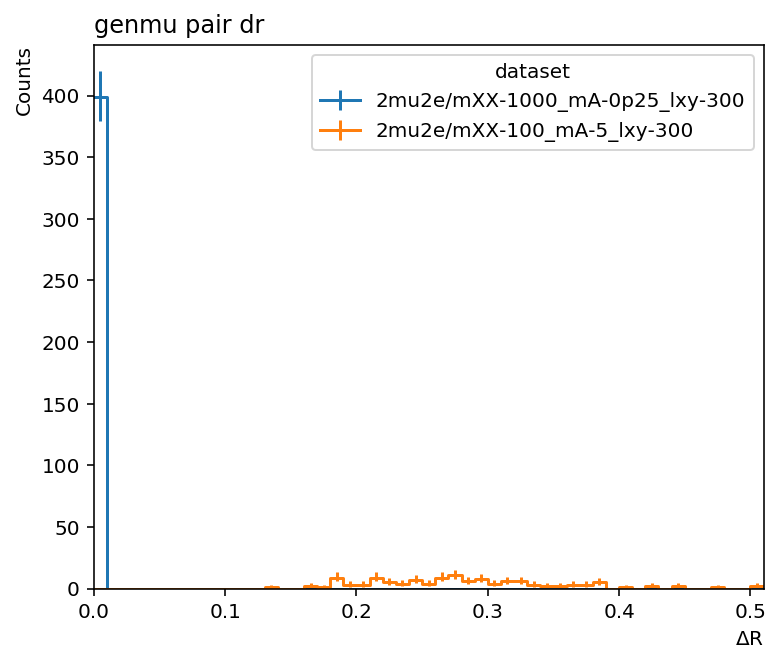

In [82]:
fig,axes=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['genmuondr'], ax=axes, overlay='dataset', overflow='over', density=False)


axes.set_title('genmu pair dr', ha='left', x=0)

# axes.set_yscale('symlog')
axes.set_xlabel(axes.get_xlabel(), x=1.0, ha="right")
axes.set_ylabel(axes.get_ylabel(), y=1.0, ha="right");

## pfmuons

In [75]:
class promptMuonProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        self._accumulator = processor.dict_accumulator({
            'cutflow': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        ## recomuons/pfmuons
        pfmuons = JaggedCandidateArray.candidatesfromcounts(
            df['pfmuon_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['pfmuon_p4.fCoordinates.fX'],
                                                 df['pfmuon_p4.fCoordinates.fY'],
                                                 df['pfmuon_p4.fCoordinates.fZ'],
                                                 df['pfmuon_p4.fCoordinates.fT']),
            selector=df['pfmuon_selectors'],
            foundadjacent=df['pfmuon_foundAdjacent'],
            foundadjacentos=df['pfmuon_foundAdjacentOS'],
        )
        pfmuons.add_attributes( isloose=(pfmuons.selector&(1<<0)==(1<<0)),
                                  ismedium=(pfmuons.selector&(1<<1)==(1<<1)),
                                  istight=(pfmuons.selector&(1<<3)==(1<<3)),
                                  pfisoveryloose=(pfmuons.selector&(1<<6)==(1<<6)),
                                  pfisoloose=(pfmuons.selector&(1<<7)==(1<<7)),
                                  pfisomedium=(pfmuons.selector&(1<<8)==(1<<8)),
                                  tkisoloose=(pfmuons.selector&(1<<11)==(1<<11)),
                                  tkisotight=(pfmuons.selector&(1<<12)==(1<<12)),
                                  intime=(pfmuons.selector&(1<<23)==(1<<23)),
                                )
                
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['gen_p4.fCoordinates.fX'],
                                                 df['gen_p4.fCoordinates.fY'],
                                                 df['gen_p4.fCoordinates.fZ'],
                                                 df['gen_p4.fCoordinates.fT']),
            pid=df['gen_pid'],
            vx=df['gen_vtx.fCoordinates.fX'],
            vy=df['gen_vtx.fCoordinates.fY'],
            vz=df['gen_vtx.fCoordinates.fZ'],
        )
        genparticles.add_attributes(vxy=np.hypot(genparticles.vx, genparticles.vy))
        genmuons = genparticles[(np.abs(genparticles.pid)==13)]

        # prompt-like
        genmuons = genmuons[genmuons.vxy<3]

        output['cutflow']['total'] += pfmuons.counts.sum()
        output['cutflow']['total-loose'] += pfmuons[pfmuons.isloose].counts.sum()
        output['cutflow']['total-medium'] += pfmuons[pfmuons.ismedium].counts.sum()
        output['cutflow']['total-tight'] += pfmuons[pfmuons.istight].counts.sum()
        output['cutflow']['total-pfisoVeryLoose'] += pfmuons[pfmuons.pfisoveryloose].counts.sum()
        output['cutflow']['total-pfisoLoose'] += pfmuons[pfmuons.pfisoloose].counts.sum()
        output['cutflow']['total-pfisoMedium'] += pfmuons[pfmuons.pfisomedium].counts.sum()
        output['cutflow']['total-looseLoose'] += pfmuons[pfmuons.pfisoloose&pfmuons.isloose].counts.sum()
        output['cutflow']['total-looseVeryloose'] += pfmuons[pfmuons.pfisoveryloose&pfmuons.isloose].counts.sum()
        output['cutflow']['total-matchedWithGen'] += pfmuons.match(genmuons, deltaRCut=0.2).flatten().sum()
        output['cutflow']['total-tkIsoLoose'] += pfmuons[pfmuons.tkisoloose].counts.sum()
        output['cutflow']['total-tkIsoTight'] += pfmuons[pfmuons.tkisotight].counts.sum()
        output['cutflow']['total-inTime'] += pfmuons[pfmuons.intime].counts.sum()
        output['cutflow']['total-comb'] += pfmuons[pfmuons.pfisoveryloose&pfmuons.isloose&pfmuons.intime].counts.sum()
        output['cutflow']['total-foundAdjacent'] += pfmuons[pfmuons.foundadjacent].counts.sum()
        output['cutflow']['total-foundAdjacentOS'] += pfmuons[pfmuons.foundadjacentos].counts.sum()
        
        output['cutflow']['total-gen'] += genmuons.counts.sum()
        output['cutflow']['matched-found'] += genmuons.match(pfmuons, deltaRCut=0.2).flatten().sum()
        
        matchedidx = genmuons.argmatch(pfmuons, deltaRCut=0.2)
        matchedRecoMu = pfmuons[matchedidx[matchedidx!=-1]]
        output['cutflow']['loose-found'] += matchedRecoMu[matchedRecoMu.isloose].counts.sum()
        output['cutflow']['medium-found'] += matchedRecoMu[matchedRecoMu.ismedium].counts.sum()
        output['cutflow']['tight-found'] += matchedRecoMu[matchedRecoMu.istight].counts.sum()
        output['cutflow']['pfisoVeryLoose-found'] += matchedRecoMu[matchedRecoMu.pfisoveryloose].counts.sum()
        output['cutflow']['pfisoLoose-found'] += matchedRecoMu[matchedRecoMu.pfisoloose].counts.sum()
        output['cutflow']['pfisoMedium-found'] += matchedRecoMu[matchedRecoMu.pfisomedium].counts.sum()
        output['cutflow']['looseLoose-found'] += matchedRecoMu[matchedRecoMu.pfisoloose&matchedRecoMu.isloose].counts.sum()
        output['cutflow']['looseVeryloose-found'] += matchedRecoMu[matchedRecoMu.pfisoveryloose&matchedRecoMu.isloose].counts.sum()
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [78]:
dataset={
#     '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
#     '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
#     '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

# dataset={
#     '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
#     '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
#     '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
# }

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=promptMuonProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 5/5 [00:03<00:00,  1.48s/items]


In [79]:
pd.Series(dict(output['cutflow']))

total                    13729
total-loose              10419
total-medium              6627
total-tight               2545
total-pfisoVeryLoose     12368
total-pfisoLoose         12185
total-pfisoMedium        12080
total-looseLoose          8907
total-looseVeryloose      9078
total-matchedWithGen       642
total-tkIsoLoose         12533
total-tkIsoTight         12414
total-inTime             13588
total-comb                8974
total-foundAdjacent       3226
total-foundAdjacentOS     2917
total-gen                  798
matched-found              784
loose-found                781
medium-found               724
tight-found                528
pfisoVeryLoose-found       783
pfisoLoose-found           773
pfisoMedium-found          773
looseLoose-found           770
looseVeryloose-found       780
dtype: int64